In [109]:
path = r"/home/kchen/Documents/AL/Data/Raw/Joined"

In [1]:
import pandas as pd
from pandas.api.types import CategoricalDtype
import numpy as np
import os

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import roc_auc_score
from xgboost.sklearn import XGBRegressor

In [3]:
#Open csv file
data = pd.read_csv(r"/home/kchen/Documents/AL/Data/Raw/Joined/combined.csv", index_col="CASEID", na_values = -99, low_memory=False)
data.head()

,Unnamed: 0,COL_STEROID,COL_STEROID_UNK,COL_MECH_BOWEL_PREP,COL_MECH_BOWEL_PREP_UNK,COL_ORAL_ANTIBIOTIC,COL_ORAL_ANTIBIOTIC_UNK,COL_CHEMO,COL_CHEMO_UNK,COL_INDICATION,...,NEURODEF,DNEURODEF,NOTHGRAFL,OTHGRAFL,DOTHGRAFL,DSDTOHD,READMISSION,UNPLANREADMISSION,REOPERATION,UNNAMED: 0
CASEID,,,,,,,,,,,,,,,,,,,,,
8080838,0,No,NaN,No,NaN,No,NaN,No,NaN,Other-Enter ICD-10 for diagnosis,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8080841,1,No,NaN,No,NaN,No,NaN,No,NaN,Colon cancer,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8080845,2,Unknown,1.0,NaN,NaN,NaN,NaN,Unknown,1.0,Other-Enter ICD-10 for diagnosis,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8080850,3,No,NaN,No,NaN,No,NaN,No,NaN,Colon cancer,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8080858,4,No,NaN,No,NaN,No,NaN,No,NaN,Other-Enter ICD-10 for diagnosis,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
cont_names = ['AGE', 'HEIGHT', 'WEIGHT', 'PRSODM', 'PRBUN', 'PRCREAT', 'PRALBUM', 'PRWBC', 'PRHCT', 'PRPLATE']
df_cont = data[cont_names]
df_cont

,AGE,HEIGHT,WEIGHT,PRSODM,PRBUN,PRCREAT,PRALBUM,PRWBC,PRHCT,PRPLATE
CASEID,,,,,,,,,,
8080838,67,68.0,122.0,137.0,39.0000,1.7500,4.3,12.00,40.0,192.0
8080841,69,66.0,156.0,141.0,13.0000,0.5900,3.0,6.70,26.9,333.0
8080845,41,68.0,209.0,140.0,19.0000,0.8000,3.8,8.50,41.1,490.0
8080850,51,70.0,173.0,137.0,20.0000,0.9800,2.7,3.20,26.2,192.0
8080858,71,64.0,147.0,139.0,25.4902,0.4525,NaN,9.70,32.0,449.0
...,...,...,...,...,...,...,...,...,...,...
7812886,70,76.0,210.0,144.0,6.0000,0.7000,NaN,7.30,34.8,212.0
7813048,55,62.0,129.0,138.0,10.0000,0.8000,3.5,5.10,25.2,456.0
7813241,29,58.0,117.0,139.0,14.0000,0.7000,4.1,14.82,42.2,256.0


In [5]:
#Create BMI column
lbs_to_kg_ratio = 0.453592
inch_to_meter_ratio = 0.0254

data['HEIGHT'] *= inch_to_meter_ratio
data['WEIGHT'] *= lbs_to_kg_ratio

data['BMI'] = data['WEIGHT']/(data['HEIGHT']**2)


In [6]:
print(min(data['BMI']))
print(max(data['BMI']))

9.097328448563147
139.05699614739444


In [13]:
#BMI BMI >50 set to 50
data.loc[data['BMI'] > 50, 'BMI'] = 50


In [14]:
print(min(data['BMI']))
print(max(data['BMI']))


9.097328448563147
50.0


In [7]:
features = ['PRNCPTX', 'CPT', 'OTHERCPT1', 'OTHERCPT2', 'OTHERCPT3', 'OTHERCPT4', 'OTHERCPT5', 'OTHERCPT6', 'OTHERCPT7', 'OTHERCPT8', 'OTHERCPT9', 'OTHERCPT10','CONCPT1', 'CONCPT2', 'CONCPT3', 'CONCPT4', 'CONCPT5', 'CONCPT6', 'CONCPT7', 'CONCPT8', 'CONCPT9', 'CONCPT10','OPERYR', 'SEX', 'AGE', 'HEIGHT', 'WEIGHT', 'BMI', 'RACE_NEW', 'ETHNICITY_HISPANIC', 'COL_INDICATION', 'COL_EMERGENT', 'COL_STEROID', 'COL_MECH_BOWEL_PREP', 'COL_ORAL_ANTIBIOTIC', 'COL_CHEMO', 'COL_APPROACH', 'COL_ICD9_INDICATION', 'TRANST','WNDCLAS','ASACLAS', 'DIABETES', 'SMOKE', 'DYSPNEA', 'FNSTATUS2', 'VENTILAT', 'HXCOPD', 'ASCITES', 'HXCHF', 'HYPERMED', 'RENAFAIL', 'DIALYSIS', 'STEROID', 'WTLOSS', 'BLEEDDIS', 'TRANSFUS', 'PRSEPIS', 'PRSODM', 'PRBUN', 'PRCREAT',  'PRALBUM', 'PRBILI', 'PRALKPH', 'PRWBC', 'PRHCT', 'PRPLATE', 'PRPTT', 'PRINR', 'PRPT', 'COL_ANASTOMOTIC']

In [8]:
#Remove unwanted columns
data = data[features]

In [9]:
print(data.columns.tolist())

['PRNCPTX', 'CPT', 'OTHERCPT1', 'OTHERCPT2', 'OTHERCPT3', 'OTHERCPT4', 'OTHERCPT5', 'OTHERCPT6', 'OTHERCPT7', 'OTHERCPT8', 'OTHERCPT9', 'OTHERCPT10', 'CONCPT1', 'CONCPT2', 'CONCPT3', 'CONCPT4', 'CONCPT5', 'CONCPT6', 'CONCPT7', 'CONCPT8', 'CONCPT9', 'CONCPT10', 'OPERYR', 'SEX', 'AGE', 'HEIGHT', 'WEIGHT', 'BMI', 'RACE_NEW', 'ETHNICITY_HISPANIC', 'COL_INDICATION', 'COL_EMERGENT', 'COL_STEROID', 'COL_MECH_BOWEL_PREP', 'COL_ORAL_ANTIBIOTIC', 'COL_CHEMO', 'COL_APPROACH', 'COL_ICD9_INDICATION', 'TRANST', 'WNDCLAS', 'ASACLAS', 'DIABETES', 'SMOKE', 'DYSPNEA', 'FNSTATUS2', 'VENTILAT', 'HXCOPD', 'ASCITES', 'HXCHF', 'HYPERMED', 'RENAFAIL', 'DIALYSIS', 'STEROID', 'WTLOSS', 'BLEEDDIS', 'TRANSFUS', 'PRSEPIS', 'PRSODM', 'PRBUN', 'PRCREAT', 'PRALBUM', 'PRBILI', 'PRALKPH', 'PRWBC', 'PRHCT', 'PRPLATE', 'PRPTT', 'PRINR', 'PRPT', 'COL_ANASTOMOTIC']


In [10]:
data.shape

(210488, 70)

In [11]:
#Fill empty CPT columns with 0
for i in range(1,11):
    data['OTHERCPT%s' % i].fillna(0, inplace=True)
    data['CONCPT%s' % i].fillna(0, inplace=True)
data.head()

,PRNCPTX,CPT,OTHERCPT1,OTHERCPT2,OTHERCPT3,OTHERCPT4,OTHERCPT5,OTHERCPT6,OTHERCPT7,OTHERCPT8,...,PRALBUM,PRBILI,PRALKPH,PRWBC,PRHCT,PRPLATE,PRPTT,PRINR,PRPT,COL_ANASTOMOTIC
CASEID,,,,,,,,,,,,,,,,,,,,,
8080838,COLECTOMY PRTL W/COLOST/ILEOST & MUCOFISTULA,44144.0,49000,0,0,0,0,0,0.0,0.0,...,4.3,0.4000,64.0,12.0,40.0,192.0,NaN,NaN,NaN,No definitive diagnosis of leak/leak related a...
8080841,COLECTOMY PRTL W/RMVL TERMINAL ILEUM & ILEOCOLOS,44160.0,44120,49203,0,0,0,0,0.0,0.0,...,3.0,0.2000,81.0,6.7,26.9,333.0,44.3,1.03,NaN,No definitive diagnosis of leak/leak related a...
8080845,LAPS COLECTOMY PRTL W/END CLST & CLSR DSTL SGM,44206.0,44206,0,0,0,0,0,0.0,0.0,...,3.8,0.2000,75.0,8.5,41.1,490.0,NaN,NaN,NaN,No definitive diagnosis of leak/leak related a...
8080850,COLECTOMY PRTL W/RMVL TERMINAL ILEUM & ILEOCOLOS,44160.0,49000,44005,44899,44120,0,0,0.0,0.0,...,2.7,0.2000,46.0,3.2,26.2,192.0,37.0,2.00,NaN,No definitive diagnosis of leak/leak related a...
8080858,COLECTOMY PRTL W/END COLOSTOMY & CLSR DSTL SGMT,44143.0,44120,44121,49020,44602,44602,44602.0,44005.0,45330.0,...,NaN,0.4094,104.0,9.7,32.0,449.0,NaN,1.00,NaN,No definitive diagnosis of leak/leak related a...


In [12]:
#Remove unwanted CPT's from CPT
ost_CPT = [44187, 44188, 44141, 44143, 44144, 44146, 44150, 44151, 44206, 44208, 44210,  44187, 44188, 44320, 44310]
for CPT in ost_CPT:
    data.drop(data[data['CPT'] == CPT].index, inplace=True)

In [13]:
#Remove unwanted CPT's from OTHER and Concurrent CPT
for CPT in ost_CPT:
    for i in range(1,11):
        data.drop(data[data['OTHERCPT%s' % i] == CPT].index, inplace=True)
        data.drop(data[data['CONCPT%s' % i] == CPT].index, inplace=True)

In [14]:
#Remove unwanted CPT's from CPT Str
str_ost = ['44187', '44188', '44141', '44143', '44144', '44146', '44150', '44151', '44206', '44208', '44210', '44187', '44188', '44320', '44310']
for CPT in str_ost:
    data.drop(data[data['CPT'] == CPT].index, inplace=True)

In [15]:
#Remove unwanted CPT's from OTHER and Concurrent CPT
for CPT in str_ost:
    for i in range(1,11):
        data.drop(data[data['OTHERCPT%s' % i] == CPT].index, inplace=True)
        data.drop(data[data['CONCPT%s' % i] == CPT].index, inplace=True)

In [16]:
#Remove unwanted indication from COL_INDICATION
data.drop(data[data['COL_INDICATION'] == 'Enterocolitis (e.g. C. Difficile)'].index, inplace=True)
data.drop(data[data['COL_INDICATION'] == 'Ulcerative colitis'].index, inplace=True)
data['COL_INDICATION'].value_counts()

Colon cancer                        61519
Chronic diverticular disease        25394
Non-malignant polyp                 16135
Other-Enter ICD-10 for diagnosis    14284
Other-Enter ICD-9 for diagnosis     11986
Crohn's Disease                      9481
Acute diverticulitis                 9282
Colon cancer w/ obstruction          6973
Volvulus                             4519
Bleeding                             1096
Unknown                               220
Name: COL_INDICATION, dtype: int64

In [17]:
data['COL_ANASTOMOTIC'].value_counts()

No definitive diagnosis of leak/leak related abscess       142737
No                                                          12279
Leak, treated w/ reoperation                                 2727
Leak, treated w/ interventional means                        1100
Leak, treated w/ non-interventional/non-operative means       667
Unknown                                                       543
Leak, no treatment intervention documented                    351
Yes-reoperation                                               299
Yes-percutaneous intervention                                 102
Yes-no intervention required                                   85
Name: COL_ANASTOMOTIC, dtype: int64

In [18]:
#Drop missing leak
le=LabelEncoder()
data['COL_ANASTOMOTIC']=le.fit_transform(data['COL_ANASTOMOTIC'])
data['COL_ANASTOMOTIC'].value_counts()

5    142737
4     12279
3      2727
1      1100
2       667
6       543
0       351
9       299
8       102
7        85
Name: COL_ANASTOMOTIC, dtype: int64

In [19]:
missing_leak = data[data['COL_ANASTOMOTIC'] == 6].index
data.drop(missing_leak, inplace=True)
data['COL_ANASTOMOTIC'].value_counts()

5    142737
4     12279
3      2727
1      1100
2       667
0       351
9       299
8       102
7        85
Name: COL_ANASTOMOTIC, dtype: int64

In [20]:
#Convert leak to binary classification
data.loc[data['COL_ANASTOMOTIC'] == 4, 'COL_ANASTOMOTIC'] = 0
data.loc[data['COL_ANASTOMOTIC'] == 5, 'COL_ANASTOMOTIC'] = 0
data['COL_ANASTOMOTIC'].astype('category')
data['COL_ANASTOMOTIC'].value_counts()

0    155367
3      2727
1      1100
2       667
9       299
8       102
7        85
Name: COL_ANASTOMOTIC, dtype: int64

In [21]:
data.loc[data['COL_ANASTOMOTIC'] != 0, 'COL_ANASTOMOTIC'] = 1
data['COL_ANASTOMOTIC'].value_counts()

0    155367
1      4980
Name: COL_ANASTOMOTIC, dtype: int64

In [22]:
data['COL_ANASTOMOTIC'].value_counts(normalize=True)

0    0.968942
1    0.031058
Name: COL_ANASTOMOTIC, dtype: float64

In [23]:
#Cast ASA class as ordered categorical
le=LabelEncoder()
cat_type = CategoricalDtype(categories=['None assigned','1-No Disturb','2-Mild Disturb','3-Severe Disturb','4-Life Threat','5-Moribund'], ordered=True)
data['ASACLAS'].astype(cat_type)


CASEID
8080841       4-Life Threat
8080850       4-Life Threat
8080874      2-Mild Disturb
8080921       4-Life Threat
8080981      2-Mild Disturb
                 ...       
7812886       4-Life Threat
7813048    3-Severe Disturb
7813241      2-Mild Disturb
7813256    3-Severe Disturb
7813386       4-Life Threat
Name: ASACLAS, Length: 160347, dtype: category
Categories (6, object): ['None assigned' < '1-No Disturb' < '2-Mild Disturb' < '3-Severe Disturb' < '4-Life Threat' < '5-Moribund']

In [24]:
#Convert 90+ to 91 and AGE to int32
data.loc[data['AGE'] == '90+', 'AGE'] = 91
pd.to_numeric(data['AGE'], downcast='integer')

CASEID
8080841    69.0
8080850    51.0
8080874    30.0
8080921    66.0
8080981    70.0
           ... 
7812886    70.0
7813048    55.0
7813241    29.0
7813256    58.0
7813386    82.0
Name: AGE, Length: 160347, dtype: float64

In [25]:
#condense col_approach
data['COL_APPROACH'].value_counts()

Laparoscopic                                          48857
Open (planned)                                        42237
Laparoscopic w/ open assist                           35809
Laparoscopic w/ unplanned conversion to open          10386
Robotic                                                7915
Robotic w/ open assist                                 4654
Open                                                   4637
Laparoscopic Hand Assisted                             2950
Laparoscopic w/ unplanned conversion to Open            907
Robotic w/ unplanned conversion to open                 695
SILS                                                    540
Hybrid                                                  240
Hybrid w/ open assist                                   154
Other                                                    87
SILS w/ open assist                                      77
Other MIS approach                                       43
SILS w/ unplanned conversion to open    

In [26]:
data.loc[data['COL_APPROACH'] == 'SILS', 'COL_APPROACH'] = 'Laparoscopic'
data.loc[data['COL_APPROACH'] == 'SILS w/ open assist', 'COL_APPROACH'] = 'Laparoscopic w/ open assist'
data.loc[data['COL_APPROACH'] == 'SILS w/ unplanned conversion to open', 'COL_APPROACH'] = 'Laparoscopic w/ unplanned conversion to open'

data.loc[data['COL_APPROACH'] == 'Endoscopic', 'COL_APPROACH'] = 'Laparoscopic'
data.loc[data['COL_APPROACH'] == 'Endoscopic w/ open assist', 'COL_APPROACH'] = 'Laparoscopic w/ open assist'
data.loc[data['COL_APPROACH'] == 'Endoscopic w/ unplanned conversion to open', 'COL_APPROACH'] = 'Laparoscopic w/ unplanned conversion to open'

data.loc[data['COL_APPROACH'] == 'NOTES', 'COL_APPROACH'] = 'Laparoscopic'
data.loc[data['COL_APPROACH'] == 'NOTES w/ open assist', 'COL_APPROACH'] = 'Laparoscopic w/ open assist'
data.loc[data['COL_APPROACH'] == 'NOTES w/ unplanned conversion to open', 'COL_APPROACH'] = 'Laparoscopic w/ unplanned conversion to open'

data.loc[data['COL_APPROACH'] == 'Other MIS approach', 'COL_APPROACH'] = 'Laparoscopic'
data.loc[data['COL_APPROACH'] == 'Other MIS approach w/ open assist', 'COL_APPROACH'] = 'Laparoscopic w/ open assist'
data.loc[data['COL_APPROACH'] == 'Other MIS approach w/ unplanned conversion to open', 'COL_APPROACH'] = 'Laparoscopic w/ unplanned conversion to open'

data.loc[data['COL_APPROACH'] == 'Hybrid', 'COL_APPROACH'] = 'Laparoscopic'
data.loc[data['COL_APPROACH'] == 'Hybrid w/ open assist', 'COL_APPROACH'] = 'Laparoscopic w/ open assist'
data.loc[data['COL_APPROACH'] == 'Hybrid w/ unplanned conversion to open', 'COL_APPROACH'] = 'Laparoscopic w/ unplanned conversion to open'

data['COL_APPROACH'].value_counts()

Laparoscopic                                    49700
Open (planned)                                  42237
Laparoscopic w/ open assist                     36077
Laparoscopic w/ unplanned conversion to open    10463
Robotic                                          7915
Robotic w/ open assist                           4654
Open                                             4637
Laparoscopic Hand Assisted                       2950
Laparoscopic w/ unplanned conversion to Open      907
Robotic w/ unplanned conversion to open           695
Other                                              87
Unknown                                            25
Name: COL_APPROACH, dtype: int64

In [41]:
#Fill missing labs with NaN (deprecate)
#labs = ['PRSODM', 'PRBUN',	'PRCREAT',	'PRALBUM',	'PRBILI', 'PRALKPH', 'PRWBC', 'PRHCT', 'PRPLATE', 'PRPTT', 'PRINR', 'PRPT']
#for lab in labs:
    data.loc[data[lab] == -99.0, lab] = np.NaN

In [28]:
#Drop rows with missing CPT
data = data[pd.notnull(data['PRNCPTX'])]

In [29]:
data.head()

,PRNCPTX,CPT,OTHERCPT1,OTHERCPT2,OTHERCPT3,OTHERCPT4,OTHERCPT5,OTHERCPT6,OTHERCPT7,OTHERCPT8,...,PRALBUM,PRBILI,PRALKPH,PRWBC,PRHCT,PRPLATE,PRPTT,PRINR,PRPT,COL_ANASTOMOTIC
CASEID,,,,,,,,,,,,,,,,,,,,,
8080841,COLECTOMY PRTL W/RMVL TERMINAL ILEUM & ILEOCOLOS,44160.0,44120,49203,0,0,0,0,0.0,0.0,...,3.0,0.2,81.0,6.70,26.9,333.0,44.3,1.03,NaN,0
8080850,COLECTOMY PRTL W/RMVL TERMINAL ILEUM & ILEOCOLOS,44160.0,49000,44005,44899,44120,0,0,0.0,0.0,...,2.7,0.2,46.0,3.20,26.2,192.0,37.0,2.00,NaN,0
8080874,LAPS COLECTOMY PRTL W/RMVL TERMINAL ILEUM,44205.0,0,0,0,0,0,0,0.0,0.0,...,3.6,0.5,82.0,10.82,35.9,360.0,30.9,1.20,NaN,0
8080921,COLECTOMY PARTIAL W/ANASTOMOSIS,44140.0,49000,0,0,0,0,0,0.0,0.0,...,2.3,3.3,143.0,8.03,22.0,101.0,83.5,1.30,NaN,0
8080981,COLECTOMY PRTL W/RMVL TERMINAL ILEUM & ILEOCOLOS,44160.0,47600,49203,47399,49000,0,0,0.0,0.0,...,4.1,0.3,188.0,10.20,42.0,238.0,NaN,NaN,NaN,0


In [60]:
#Fill NaN labs with median value
#my_imputer = SimpleImputer(strategy='median')
#data_labs_med = pd.DataFrame(my_imputer.fit_transform(data[labs]))

#data_labs_med = data_labs_med()


ValueError: Length mismatch: Expected axis has 12 elements, new values have 69 elements

In [71]:
# Apply label encoder to each column with categorical data
label_encoder = LabelEncoder()
for col in categorical_cols:
    X_train_label[col] = label_encoder.fit_transform(X_train_full[col].astype(str))
    X_valid_label[col] = label_encoder.fit_transform(X_valid_full[col].astype(str))

    

In [72]:
my_imputer = SimpleImputer(strategy='most_frequent')

# Imputation
imputed_X_train = pd.DataFrame(my_imputer.fit_transform(X_train_label))
imputed_X_valid = pd.DataFrame(my_imputer.transform(X_valid_label))


# Imputation removed column names; put them back
imputed_X_train.columns = X_train_label.columns
imputed_X_valid.columns = X_valid_label.columns

In [30]:
data.to_csv(r'/home/kchen/Documents/AL/Data/data1.csv', index=True)

In [94]:
data = pd.read_csv(r'/home/kchen/Documents/AL/Data/data3.csv', index_col='CASEID')
data.head()

/home/kchen/.local/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (3,4,5,6,7,8,13,14,15) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,PRNCPTX,CPT,OTHERCPT1,OTHERCPT2,OTHERCPT3,OTHERCPT4,OTHERCPT5,OTHERCPT6,OTHERCPT7,OTHERCPT8,...,PRALBUM,PRBILI,PRALKPH,PRWBC,PRHCT,PRPLATE,PRPTT,PRINR,PRPT,COL_ANASTOMOTIC
CASEID,,,,,,,,,,,,,,,,,,,,,
8080841,COLECTOMY PRTL W/RMVL TERMINAL ILEUM & ILEOCOLOS,44160.0,44120,49203,0,0,0,0.0,0.0,0.0,...,3.0,0.2,81.0,6.70,26.9,333.0,44.3,1.03,NaN,0
8080850,COLECTOMY PRTL W/RMVL TERMINAL ILEUM & ILEOCOLOS,44160.0,49000,44005,44899,44120,0,0.0,0.0,0.0,...,2.7,0.2,46.0,3.20,26.2,192.0,37.0,2.00,NaN,0
8080874,LAPS COLECTOMY PRTL W/RMVL TERMINAL ILEUM,44205.0,0,0,0,0,0,0.0,0.0,0.0,...,3.6,0.5,82.0,10.82,35.9,360.0,30.9,1.20,NaN,0
8080921,COLECTOMY PARTIAL W/ANASTOMOSIS,44140.0,49000,0,0,0,0,0.0,0.0,0.0,...,2.3,3.3,143.0,8.03,22.0,101.0,83.5,1.30,NaN,0
8080981,COLECTOMY PRTL W/RMVL TERMINAL ILEUM & ILEOCOLOS,44160.0,47600,49203,47399,49000,0,0.0,0.0,0.0,...,4.1,0.3,188.0,10.20,42.0,238.0,NaN,NaN,NaN,0


In [61]:
#Split into training and test data
y = data['COL_ANASTOMOTIC']
features = ['PRNCPTX', 'CPT', 'OTHERCPT1', 'OTHERCPT2', 'OTHERCPT3', 'OTHERCPT4', 'OTHERCPT5', 'OTHERCPT6', 'OTHERCPT7', 'OTHERCPT8', 'OTHERCPT9', 'OTHERCPT10','CONCPT1', 'CONCPT2', 'CONCPT3', 'CONCPT4', 'CONCPT5', 'CONCPT6', 'CONCPT7', 'CONCPT8', 'CONCPT9', 'CONCPT10','OPERYR', 'SEX', 'AGE', 'HEIGHT', 'WEIGHT', 'BMI', 'RACE_NEW', 'ETHNICITY_HISPANIC', 'COL_INDICATION', 'COL_EMERGENT', 'COL_STEROID', 'COL_MECH_BOWEL_PREP', 'COL_ORAL_ANTIBIOTIC', 'COL_CHEMO', 'INOUT', 'TRANST','WNDCLAS','ASACLAS', 'DIABETES', 'SMOKE', 'DYSPNEA', 'FNSTATUS2', 'VENTILAT', 'HXCOPD', 'ASCITES', 'HXCHF', 'HYPERMED', 'RENAFAIL', 'DIALYSIS', 'STEROID', 'WTLOSS', 'BLEEDDIS', 'TRANSFUS', 'PRSEPIS', 'PRSODM', 'PRBUN', 'PRCREAT',  'PRALBUM', 'PRBILI', 'PRALKPH', 'PRWBC', 'PRHCT', 'PRPLATE', 'PRPTT', 'PRINR', 'PRPT', 'COL_ANASTOMOTIC']
X = data[features]
X_train_full, X_valid_full, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=0)

In [69]:
# Assign categorical and numerical columns
add_cat = ['CPT', 'OTHERCPT6', 'OTHERCPT7', 'OTHERCPT8', 'OTHERCPT9', 'OTHERCPT10', 'CONCPT2', 'CONCPT3', 'CONCPT4', 'CONCPT5', 'CONCPT6', 'CONCPT7', 'CONCPT8', 'CONCPT9', 'CONCPT10', 'OPERYR']
data[add_cat].astype('category')
categorical_cols = ['PRNCPTX', 'OTHERCPT1', 'OTHERCPT2', 'OTHERCPT3', 'OTHERCPT4', 'OTHERCPT5', 'CONCPT1', 'COL_STEROID', 'COL_MECH_BOWEL_PREP', 'COL_ORAL_ANTIBIOTIC', 'COL_CHEMO', 'COL_INDICATION', 'COL_EMERGENT', 'SEX', 'RACE_NEW', 'ETHNICITY_HISPANIC', 'DIABETES', 'SMOKE', 'DYSPNEA', 'FNSTATUS2', 'VENTILAT', 'HXCOPD', 'ASCITES', 'HXCHF', 'HYPERMED', 'RENAFAIL', 'DIALYSIS', 'STEROID', 'WTLOSS', 'BLEEDDIS', 'TRANSFUS', 'PRSEPIS', 'ASACLAS', 'INOUT', 'TRANST','WNDCLAS', 'CPT', 'OTHERCPT6', 'OTHERCPT7', 'OTHERCPT8', 'OTHERCPT9', 'OTHERCPT10', 'CONCPT2', 'CONCPT3', 'CONCPT4', 'CONCPT5', 'CONCPT6', 'CONCPT7', 'CONCPT8', 'CONCPT9', 'CONCPT10', 'OPERYR']
numerical_cols = ['AGE', 'HEIGHT', 'WEIGHT', 'BMI', 'PRSODM', 'PRBUN', 'PRCREAT', 'PRALBUM', 'PRBILI', 'PRALKPH', 'PRWBC', 'PRHCT', 'PRPLATE', 'PRPTT', 'PRINR', 'PRPT']
print(categorical_cols)
print(numerical_cols)

['PRNCPTX', 'OTHERCPT1', 'OTHERCPT2', 'OTHERCPT3', 'OTHERCPT4', 'OTHERCPT5', 'CONCPT1', 'COL_STEROID', 'COL_MECH_BOWEL_PREP', 'COL_ORAL_ANTIBIOTIC', 'COL_CHEMO', 'COL_INDICATION', 'COL_EMERGENT', 'SEX', 'RACE_NEW', 'ETHNICITY_HISPANIC', 'DIABETES', 'SMOKE', 'DYSPNEA', 'FNSTATUS2', 'VENTILAT', 'HXCOPD', 'ASCITES', 'HXCHF', 'HYPERMED', 'RENAFAIL', 'DIALYSIS', 'STEROID', 'WTLOSS', 'BLEEDDIS', 'TRANSFUS', 'PRSEPIS', 'ASACLAS', 'INOUT', 'TRANST', 'WNDCLAS', 'CPT', 'OTHERCPT6', 'OTHERCPT7', 'OTHERCPT8', 'OTHERCPT9', 'OTHERCPT10', 'CONCPT2', 'CONCPT3', 'CONCPT4', 'CONCPT5', 'CONCPT6', 'CONCPT7', 'CONCPT8', 'CONCPT9', 'CONCPT10', 'OPERYR']
['AGE', 'HEIGHT', 'WEIGHT', 'BMI', 'PRSODM', 'PRBUN', 'PRCREAT', 'PRALBUM', 'PRBILI', 'PRALKPH', 'PRWBC', 'PRHCT', 'PRPLATE', 'PRPTT', 'PRINR', 'PRPT']


In [70]:
X_train_label = X_train_full.copy()
X_valid_label = X_valid_full.copy()


In [68]:
X_train_label.head(10)

,PRNCPTX,CPT,OTHERCPT1,OTHERCPT2,OTHERCPT3,OTHERCPT4,OTHERCPT5,OTHERCPT6,OTHERCPT7,OTHERCPT8,...,PRCREAT,PRALBUM,PRBILI,PRALKPH,PRWBC,PRHCT,PRPLATE,PRPTT,PRINR,PRPT
CASEID,,,,,,,,,,,,,,,,,,,,,
3276710,4,3,699,0,0,0,0,0,0,0,...,0.8000,3.8,0.5000,86.0,6.9,29.5,176.0,NaN,1.20,NaN
8847998,6,4,0,0,0,0,0,0,0,0,...,1.8300,6.6,2.2200,82.0,7.4,31.0,163.0,26.8,1.03,NaN
6660772,0,0,0,0,0,0,0,0,0,0,...,0.7000,3.4,0.5000,91.0,7.4,37.5,525.0,25.0,1.00,NaN
4458119,8,5,470,0,0,0,0,0,0,0,...,0.9000,3.3,0.2000,49.0,3.9,29.1,107.0,23.6,1.00,NaN
4946514,6,4,393,449,0,0,0,0,0,0,...,0.4400,4.1,0.7000,76.0,6.7,38.8,178.0,NaN,NaN,NaN
5099056,7,6,0,0,0,0,0,0,0,0,...,0.6787,3.8,0.2339,91.0,7.4,44.0,250.0,23.0,1.00,NaN
3335314,3,1,0,0,0,0,0,0,0,0,...,1.8000,NaN,NaN,NaN,7.7,29.4,171.0,NaN,NaN,NaN
6672173,8,5,0,0,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4007326,0,0,0,0,0,0,0,0,0,0,...,0.8800,4.2,0.6000,84.0,4.2,40.3,96.0,NaN,NaN,NaN


In [73]:
# Define model, predict, score
model1 = RandomForestClassifier(n_estimators=1000, random_state=0)
model1.fit(imputed_X_train, y_train)
preds = model1.predict(imputed_X_valid)
score = roc_auc_score(y_valid, preds)
print('AUC:', score)

AUC: 0.4999697501361244


In [51]:
model2 = XGBRegressor()
model2.fit(imputed_X_train, y_train)
preds2 = model2.predict(imputed_X_valid)
score2 = roc_auc_score(y_valid, preds2)
print('AUC:', score2)

ValueError: DataFrame.dtypes for data must be int, float, bool or categorical.  When
                categorical type is supplied, DMatrix parameter
                `enable_categorical` must be set to `True`.PRNCPTX, CPT, OTHERCPT1, OTHERCPT2, OTHERCPT3, OTHERCPT4, OTHERCPT5, OTHERCPT6, OTHERCPT7, OTHERCPT8, OTHERCPT9, OTHERCPT10, CONCPT1, CONCPT2, CONCPT3, CONCPT4, CONCPT5, CONCPT6, CONCPT7, CONCPT8, CONCPT9, CONCPT10, COL_STEROID, COL_MECH_BOWEL_PREP, COL_ORAL_ANTIBIOTIC, COL_CHEMO, COL_INDICATION, COL_EMERGENT, OPERYR, SEX, AGE, HEIGHT, WEIGHT, RACE_NEW, ETHNICITY_HISPANIC, DIABETES, SMOKE, DYSPNEA, FNSTATUS2, VENTILAT, HXCOPD, ASCITES, HXCHF, HYPERMED, RENAFAIL, DIALYSIS, STEROID, WTLOSS, BLEEDDIS, TRANSFUS, PRSEPIS, PRSODM, PRBUN, PRCREAT, PRALBUM, PRBILI, PRALKPH, PRWBC, PRHCT, PRPLATE, PRPTT, PRINR, PRPT, ASACLAS

In [75]:
print(preds)

[0 0 0 ... 0 0 0]


In [76]:
def rf_feat_importance(model1, X):
    return pd.DataFrame({'cols':X.columns, 'imp':model1.feature_importances_}
                       ).sort_values('imp', ascending=False)

In [77]:
fi = rf_feat_importance(model1, X)
fi[:10]

,cols,imp
27,BMI,0.061827
64,PRPLATE,0.058777
63,PRHCT,0.057671
26,WEIGHT,0.056203
62,PRWBC,0.055745
58,PRCREAT,0.052282
61,PRALKPH,0.046748
57,PRBUN,0.045780
25,HEIGHT,0.040739
56,PRSODM,0.039251


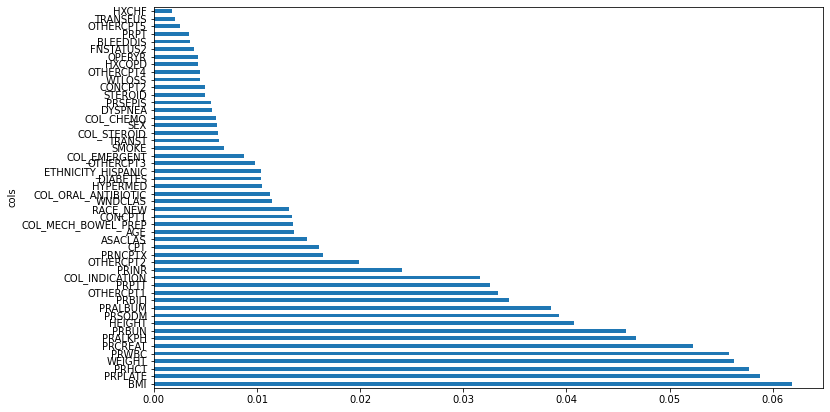

In [78]:
def plot_fi(fi):
    return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

plot_fi(fi[:50]);